In [109]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

## Load target image

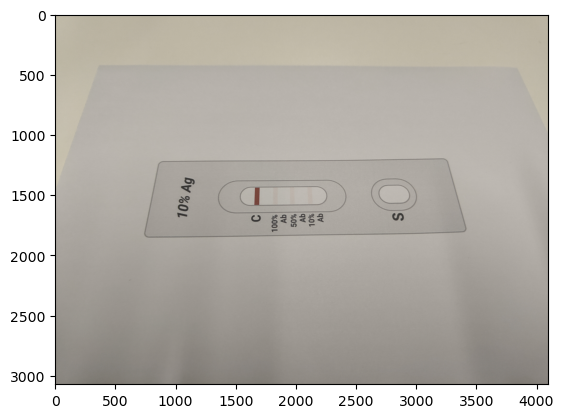

In [110]:
# tag = "ag10.png"
tag = "ag10_1.jpg"
# tag = "ag20.png"
# tag = "ag20_1.jpg"
# tag = "ag50.png"
# tag = "ag90.png"
# tag = "ag100.png"

image = cv2.imread(f'../assets/test_imgs/{tag}')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image)

In [111]:
def show(images):
    fig, axes = plt.subplots(1, len(images), figsize=(20, 10))
    if len(images) == 1:
        plt.imshow(images[0])
    else:
        for i, img in enumerate(images):
            if img.ndim == 2:
                axes[i].imshow(img, cmap='gray')
            else:
                axes[i].imshow(img)
        plt.show()

## Crop out the region of interest

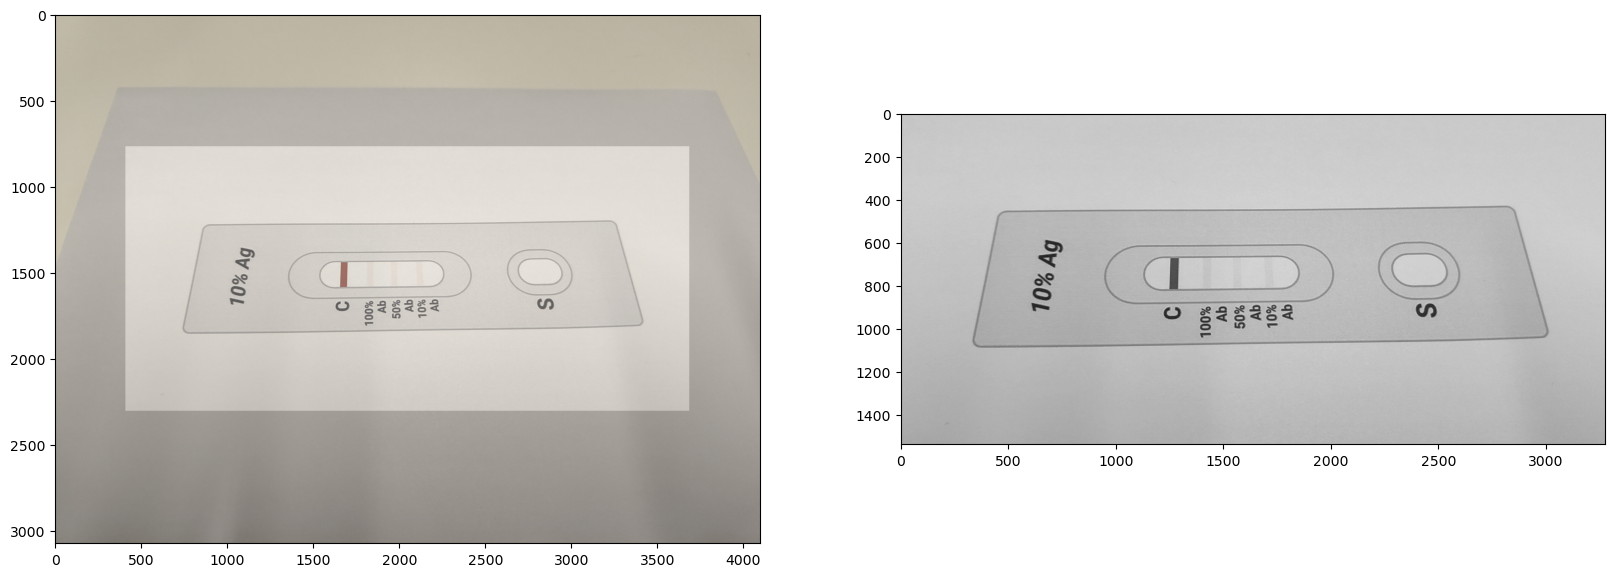

In [112]:
# region of interest
h, w, c = image.shape

xCrop = 0.10
yCrop = 0.25
x = int(w * xCrop)
width = int(w * (1 - 2 * xCrop))
y = int(h * yCrop)
height = int(h * (1 - 2 * yCrop))


# w_min, w_max = int(w*0.15), int(w*0.85)
# h_min, h_max = int(h*0.2), int(h*0.8)
image_region = image.copy()
image_region[y:y+height, x:x+width] += 40
image_region[image_region>255] = 255

roi = image[y:y+height, x:x+width]
gray = cv2.cvtColor(roi, cv2.COLOR_RGB2GRAY)

show([image_region, gray])

## Detect edge & Warp image

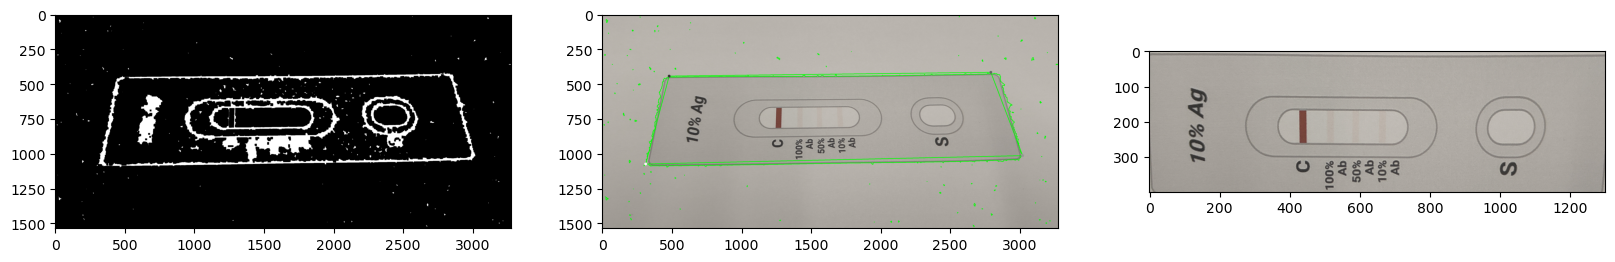

In [113]:
clahe = cv2.createCLAHE(clipLimit=1.0, tileGridSize=(8, 8))
c_enhance = clahe.apply(gray)
edges = cv2.Canny(c_enhance, 50, 200)

# apply morphological operations
kernel = np.ones((3, 3), np.uint8)
edges = cv2.morphologyEx(edges, cv2.MORPH_CLOSE, kernel, iterations=6)

# find outer contours
contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
contours = sorted(contours, key=cv2.contourArea, reverse=True)

# find the largest rectangle
for contour in contours:
    epsilon = 0.02 * cv2.arcLength(contour, True)
    approx = cv2.approxPolyDP(contour, epsilon, True)
    if len(approx) == 4:
        break

roi_ = roi.copy()
cv2.drawContours(roi_, contours, -1, (0, 255, 0), 3)

cv2.drawContours(roi_, [approx], -1, (0, 255, 0), 3)

# find corner
approx = approx.reshape(4, 2)
corner = np.zeros((4, 2), dtype=np.float32)

# top-left corner has the smallest sum
corner[0] = approx[np.argmin(np.sum(approx, axis=1))]

# bottom-right corner has the largest sum
corner[2] = approx[np.argmax(np.sum(approx, axis=1))]

# top-right corner has the smallest difference
corner[1] = approx[np.argmin(np.diff(approx, axis=1))]
# bottom-left corner has the largest difference
corner[3] = approx[np.argmax(np.diff(approx, axis=1))]

cv2.circle(roi_, corner[0].astype(int), 10, np.ones(3)*50, -1)
cv2.circle(roi_, corner[1].astype(int), 10, np.ones(3)*100, -1)
cv2.circle(roi_, corner[2].astype(int), 10, np.ones(3)*150, -1)
cv2.circle(roi_, corner[3].astype(int), 10, np.ones(3)*250, -1)

# perspective transform
width = 1300
height = 400
dst = np.array([[0, 0], [width-1, 0], [width-1, height-1], [0, height-1]], dtype=np.float32)
matrix = cv2.getPerspectiveTransform(corner, dst)
warped = cv2.warpPerspective(roi, matrix, (width, height))

show([edges, roi_, warped])

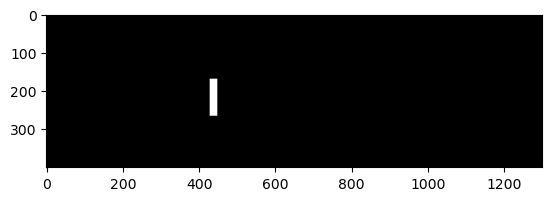

In [114]:
# find vertical lines
gray = cv2.cvtColor(warped, cv2.COLOR_RGB2GRAY)
plt.imshow(gray, cmap='gray')

clahe = cv2.createCLAHE(clipLimit=1.0, tileGridSize=(8, 8))
gray = clahe.apply(gray)
plt.imshow(gray, cmap='gray')

# apply adaptive threshold
_, binary = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
# binary = cv2.adaptiveThreshold(gray,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY,11,2)
# plt.imshow(binary, cmap='gray')

# apply morphological operations
kernel = np.ones((5, 5), np.uint8)
binary = cv2.morphologyEx(binary, cv2.MORPH_OPEN, kernel, iterations=3)
# plt.imshow(binary, cmap='gray')

# find vertical lines
vertical_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1, 5))
vertical_lines = cv2.morphologyEx(binary, cv2.MORPH_OPEN, vertical_kernel, iterations=5)
plt.imshow(vertical_lines, cmap='gray')

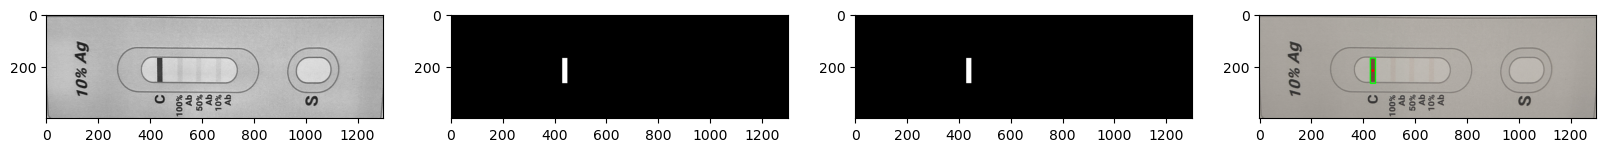

[(429, 169, 20, 97)]

In [115]:
def find_vertical_stripes(image):
    # find vertical lines
    gray = cv2.cvtColor(warped, cv2.COLOR_RGB2GRAY)

    clahe = cv2.createCLAHE(clipLimit=1.0, tileGridSize=(8, 8))
    gray = clahe.apply(gray)

    # blur
    # blurred = cv2.GaussianBlur(gray, (3, 3), 0)
    # apply adaptive threshold
    _, binary = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
    # binary = cv2.adaptiveThreshold(gray,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY,11,2)

    # apply morphological operations
    kernel = np.ones((5, 5), np.uint8)
    binary = cv2.morphologyEx(binary, cv2.MORPH_OPEN, kernel, iterations=3)

    # find vertical lines
    vertical_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1, 5))
    vertical_lines = cv2.morphologyEx(binary, cv2.MORPH_OPEN, vertical_kernel, iterations=5)

    # find line small rectangle contours
    contours, _ = cv2.findContours(vertical_lines, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contours = sorted(contours, key=cv2.contourArea, reverse=True)
    rects = []
    for contour in contours:
        x, y, w, h = cv2.boundingRect(contour)
        rects.append((x, y, w, h))
        cv2.rectangle(image, (x, y), (x+w, y+h), (0, 255, 0), 3)
        # draw center
        cv2.circle(image, (x+w//2, y+h//2), 5, (255, 0, 0), -1)

    return rects, [gray, binary, vertical_lines, image]

rects, images = find_vertical_stripes(warped.copy())
show(images)
rects

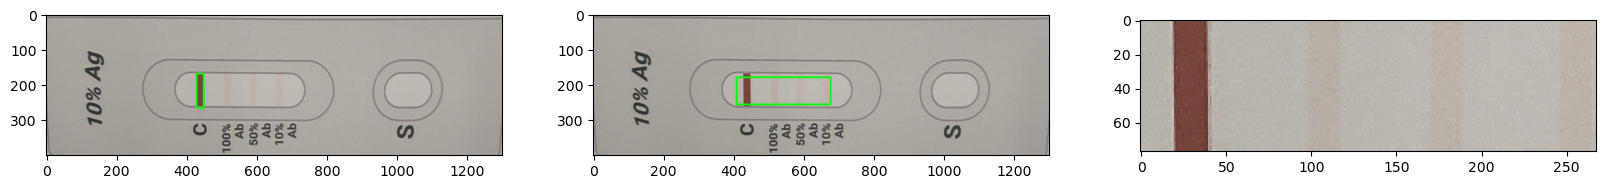

In [116]:
def get_reference(rects):
    rects = np.array(rects)
    centers = np.array([(x+w//2, y+h//2) for (x, y, w, h) in rects])
    left_most_x = min([center[0] for center in centers])
    is_left = left_most_x < warped.shape[1]//2
    # the first item is the reference
    return rects[centers[:, 0].argsort()[::1 if is_left else -1]][0], is_left

reference, is_left = get_reference(rects)
reference, is_left

image_ref = warped.copy()
x, y, w, h = reference
cv2.rectangle(image_ref, (x, y), (x+w, y+h), (0, 255, 0), 3)

def get_inspection_area(reference, is_left, factor=2.15, x_padding=20, y_padding=10):
    x, y, w, h = reference
    window_w = int(factor*h)
    if is_left:
        return x-x_padding, y+y_padding, w+window_w+2*x_padding, h-2*y_padding
    else:
        return x-window_w-x_padding, y+y_padding, w+window_w+2*x_padding, h-2*y_padding


image_insp = warped.copy()
x, y, w, h = get_inspection_area(reference, is_left)
cv2.rectangle(image_insp, (x, y), (x+w, y+h), (0, 255, 0), 3)

inspection_roi = warped[y:y+h, x:x+w]

show([image_ref, image_insp, inspection_roi])

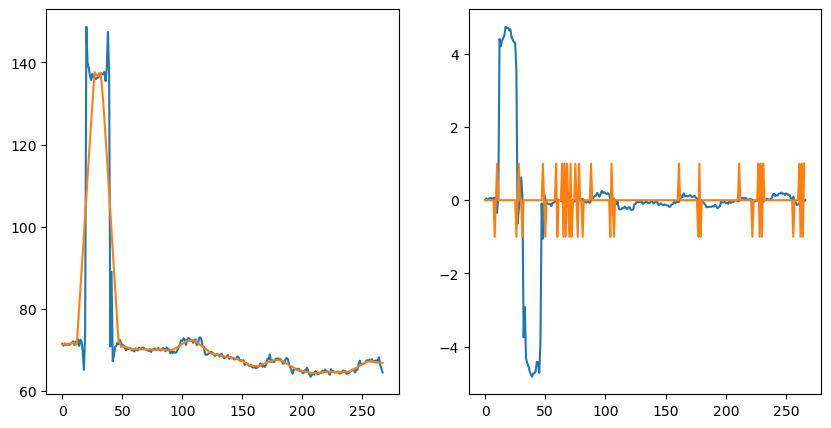

In [117]:
red_curve = 255-inspection_roi[..., 0].mean(axis=0)
# smooth the curve
smoothed = cv2.GaussianBlur(red_curve, (15, 15), 10)

derivative = np.diff(smoothed.flatten())
sign_change = np.diff(np.sign(derivative))/2

# plot two curves
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].plot(red_curve)
axes[0].plot(smoothed)
axes[1].plot(derivative)
axes[1].plot(sign_change)
plt.show()

In [118]:
# 10% => array([147.89484106,  72.96602748,  74.41298021,  76.3338441 ])
# 20% => array([147.56536914,  84.98838378,  84.9831624 ,  75.77732638])
# 50% => array([136.96530849, 102.58850471, 103.05605694,  74.727039  ])
# 90% => array([141.43094518, 139.92400184, 105.03227822,  69.30614486])
# 100% => array([144.30175901, 144.93463486, 105.85978789,  80.65702497])

bar_value = smoothed[:smoothed.shape[0] - (smoothed.shape[0] % 4)].reshape(4, -1).max(axis=1)[::1 if is_left else -1]
bar_value

array([137.66859212,  72.2462656 ,  68.43891884,  67.22467163])

In [119]:
min_ref = smoothed[:smoothed.shape[0] - (smoothed.shape[0] % 4)].reshape(4, -1).min(axis=1).mean()
min_ref

66.92314687048889

In [120]:
bar_value = bar_value - min_ref
bar_value = bar_value / bar_value[0] * 100
bar_value

array([100.        ,   7.52432713,   2.14257181,   0.42621084])

In [121]:
def lateral_flow_res(bar_value):
    if bar_value[1] > 50:
        value = bar_value[1]
    elif bar_value[2] > 10:
        value = bar_value[2]
    else:
        value = bar_value[3]
    value = min(value, 100)
    value = max(value, 0)
    return value

In [122]:
lateral_flow_res(bar_value)

0.4262108443539428